##**Context encoder model using Pytorch**


In this notebook, We designed algorithms and models to inpaint joints in knee radiographs by using Context encoders.

# Recreating knee radiographs without artifacts Using Generative AI

by [Arun Sivakumar](https://www.linkedin.com/in/arunsivakumarr/)

The project is broken down into multiple steps:
* Building and creating an inpainting model using pytorch
* Using encoder part of the architecture to inpaint knee radiographs without surgical artifacts to enrich dataset.


### **Importing  the Librairies**

In [ ]:
import numpy as np
import torch
from torch import nn
import random
import torchvision.transforms.functional as TF
from PIL import Image
from IPython.display import display
from torchvision.transforms import ToPILImage
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from scipy.linalg import sqrtm
import cv2
from google.colab.patches import cv2_imshow
import skimage.exposure
import matplotlib.pyplot as plt
import time
from google_drive_downloader import GoogleDriveDownloader as gdd
import gdown
import zipfile
import shutil
from google.colab import files
import glob
import re
import warnings
import torchvision.models as models
import matplotlib.pyplot as plt
from google.colab import drive
import os
from IPython.display import clear_output
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [ ]:
# verify pytorch version

print("PyTorch Version: ", torch.__version__)
print("GPU is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")


PyTorch Version:  2.0.1+cu118
GPU is NOT AVAILABLE


### Load the data

We will download our dataset of 7434 images of unlabeled knee radiographs.

In [ ]:
def get_files(device='cpu', path="/content/",file='dataset'):
    if file=='saved_weights':
      url_weights = 'https://drive.google.com/uc?id=1-7lGOKwoeGwGwbCOJXMviSjXl5gL_w2P'
      gdown.download(url_weights, path, quiet=True)
      with zipfile.ZipFile('/content/weights_49.zip', 'r') as ziphandler:
          ziphandler.extractall('/content/')
      url_res = 'https://drive.google.com/uc?id=1-Zf63df0hRuHUOA__PPRLcUF4qrPsNW8'
      gdown.download(url_res, path, quiet=True)
      with zipfile.ZipFile('/content/results_47.zip', 'r') as ziphandler:
          ziphandler.extractall('/content/')
      url_metrics = 'https://drive.google.com/uc?id=1f-qI8O-PH1eLhe53ZYPJwleqTLgHnYsb'
      gdown.download(url_metrics, path, quiet=True)
      with zipfile.ZipFile('/content/lists.zip', 'r') as ziphandler:
          ziphandler.extractall('/content/')
    else:
      url = 'https://drive.google.com/uc?id=13B1Fg0ttENKqkkG1SfiMN4N0g5BFGnI9'
      gdown.download(url, path, quiet=False)
      with zipfile.ZipFile('/content/Data-20230610T002016Z-001.zip', 'r') as ziphandler:
          ziphandler.extractall('/content/')
          print("Download complete!")
    return

get_files()

Downloading...
From: https://drive.google.com/uc?id=13B1Fg0ttENKqkkG1SfiMN4N0g5BFGnI9
To: /content/Data-20230610T002016Z-001.zip
100%|██████████| 272M/272M [00:02<00:00, 98.6MB/s]


Download complete!


### Data Preprocessing

We will need to make sure that the training data does not include artifacts (ie) X-rays with surgery prosthetics as evidence from [1] suggests that a generative model’s performance is adversely affected by anomalies.

In [ ]:
remove_artifacts = True #@param {type:"boolean"}
root = "Data/Unlabeled/"
output_folder = "Data/Artifacts/"

if remove_artifacts:
  # Through manual inspection remove images that has surgical prosthetics
  image_list = ["3173", "4630", "5367","4346","4677","5797","4867","1005","7345","3271","1220","4003","6104","1190","7180"]
  if not os.path.exists(output_folder):
        os.makedirs(output_folder)
  for image_file in image_list:
      image_path = os.path.join(root, 'unlabeled_image'+image_file +'.png')
      if os.path.exists(image_path):
          destination_path = os.path.join(output_folder, 'unlabeled_image' + image_file + '.png')
          shutil.move(image_path, destination_path)
          print(f"Moved {image_file} to {output_folder}")
      else:
          print(f"{image_file} does not exist")

Moved 3173 to Data/Artifacts/
Moved 4630 to Data/Artifacts/
Moved 5367 to Data/Artifacts/
Moved 4346 to Data/Artifacts/
Moved 4677 to Data/Artifacts/
Moved 5797 to Data/Artifacts/
Moved 4867 to Data/Artifacts/
Moved 1005 to Data/Artifacts/
Moved 7345 to Data/Artifacts/
Moved 3271 to Data/Artifacts/
Moved 1220 to Data/Artifacts/
Moved 4003 to Data/Artifacts/
Moved 6104 to Data/Artifacts/
Moved 1190 to Data/Artifacts/
Moved 7180 to Data/Artifacts/


Let's set up data loaders that will read pictures in our unlabeled folders, convert them to `float32` tensors, and feed them  to our generative network.Additionally,we resize the image to be 210x210 as done by [1] to train our model within the constraints of the available CPU memory.

We extract a centeral rectangular patch of size 112x162x1 from the input image to form a cropped input image. A rectangular patch is more intutive for our experiments, since it covers the entire joint region which is used to determine Osteoarthritis severity.

We observed two types of knee radiograph images that could affect the performance of our generative model
*  Negative images
*  Unfocused blurry knee radiographs



Negative images:

We observed that there are negative present in our dataset, these images could affect training of our generative model, as the model could focus on recreating negative images with lower pixel intensity values instead of creating examples that effectively recreate the knee joints with different level of progressions.

To address this issue, we detect negative images by checking if any pixel value exceeds a certain limit and perform image inversion and contrast equalization to produce corrected images which are fed down the pipeline.

Unfocused knee radiographs:

In order to address unfocused knee radiographs that could have an adverse effect similar to negative images, we use laplacian filter to separate out blurry images. This is done by calculating a focus metric, that is calculated as the variance of the absolute values for the image convolved by a laplacian filter.A threshold of 400 was determined to filter our images and images exceeding this threshold was removed as "blurry" while the images with a value less than the threshold were sent into our generative model for training.

Intially, we train our model without removing blurry images and after observing that the FID scores do not decrease as we train our model, we switch on focus thresholding which is seen as follows. This acts as an ablation study and stresses importance of each preprocessing technique.


In [ ]:
def is_bone_image(image, threshold):
    """
    Function to check if a given image is a negative image by checking if any pixel intensity
    values exceeds a threshold.
    """
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    is_bone = cv2.countNonZero(binary_image) > 0
    return is_bone


def focus_thresholding(image, thresh=400):
    """
    Function to check the overall blurriness of an image by calculating the laplacian variance metric
    and reject the image as blurry if the laplacian variance metric exceeds threshold.
    """
    laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    laplacian_image = cv2.filter2D(image, -1, laplacian_kernel)
    laplacian_variance = np.var(np.abs(laplacian_image))
    if laplacian_variance < thresh:
        return "Blurry"
    else:
        return "Focused"


def correct_if_negative(image):
    """
    Function to check if the image is negative and correct the image through image inversion
    and contrast equalization before checking for overall blurriness of an image
    """
    if is_bone_image(image, threshold=220):
        if focus_thresholding(image) == "Focused":
            return image
        else:
            return "rejected"
    else:

        # Invert negative channel images
        inverted_image = cv2.bitwise_not(image)
        # Perform contrast equalization
        equalized_image = skimage.exposure.equalize_adapthist(
            inverted_image, kernel_size=None, clip_limit=0.01, nbins=256
        )
        # Scale the image to the range [0, 255]
        scaled_image = skimage.exposure.rescale_intensity(
            equalized_image, out_range=(0, 255)
        )
        final_image = scaled_image.astype(np.uint8)
        if focus_thresholding(final_image) == "Focused":
            return final_image
        else:
            return "rejected"


class SingleClassDataset(Dataset):
    """
    Dataset for returning two images: the original image without center (without context)
    and rectangular center crop of the image (context).
    """
    def __init__(
        self,
        root,
        crop_length,
        make_corrections,
        Focus_thresholding=False,
        transform=None,
    ):
        root = root + "/*.png"
        self.transform = transform
        self.make_corrections = make_corrections
        self.Focus_thresholding = Focus_thresholding
        self.rejected = 0
        files = sorted(
            glob.glob(root),
            key=lambda var: [
                int(x) if x.isdigit() else x for x in re.findall(r"[^0-9]|[0-9]+", var)
            ],
        )
        self.dataset = files
        self.crop_length = crop_length

    def get_normed(self, this_array, this_min=0, this_max=255, set_to_int=False):
        """
        Takes input image as an array (image to be normalized) and gives normalized version of the image
        """
        rat = (this_max - this_min) / (this_array.max() - this_array.min())
        this_array = this_array * rat
        this_array -= this_array.min()
        this_array += this_min
        if set_to_int:
            return this_array.to(dtype=torch.int) / this_max
        return this_array / this_max

    def find_bone_image(self, sample, threshold, index):
        """
        Reads image file and checks if the image is a bone image or a negative image and
        recursively checks the next sample
        """
        image = cv2.imread(sample, cv2.IMREAD_GRAYSCALE)
        if is_bone_image(image, threshold):
            return Image.open(sample)
        else:
            self.rejected += 1
        # Recursively try the next sample
        return self.find_bone_image(self.dataset[index + 1], threshold, index + 1)

    def __len__(self):
        return len(self.dataset)

    def get_rejected_count(self):
        """
        Returns the number of rejected images.
        """
        return self.rejected

    def __getitem__(self, index):
        """

        """
        self.id = self.dataset[index]
        if self.make_corrections:
            image = cv2.imread(self.id, cv2.IMREAD_GRAYSCALE)
            image = correct_if_negative(image)
            if image == "rejected":
                # Move to the next ID
                self.rejected += 1
                return self.__getitem__(index + 1)
            else:
                image = Image.fromarray(np.uint8(image))
        else:
            image = self.find_bone_image(self.id, threshold=220, index=index)
            if focus_thresholding(np.array(image), thresh=120) == "Focused":
                pass
            else:
                self.rejected += 1
                try:
                    return self.__getitem__(index + 1)
                except:
                    # Randomly select an index from the dataset to promote indeterministic sampling
                    chosen_index = random.sample(range(len(dataset)), 1)[0]
                    return self.__getitem__(chosen_index)

        # Calculate the coordinates for the middle region
        start_x = image.size[0] // 4
        start_y = image.size[1] // 4
        end_x = start_x + image.size[0] // 2
        end_y = start_y + image.size[1] // 2
        # Increase the length of the square to capture the entire knee joint region
        length_increase = self.crop_length
        start_x -= length_increase
        end_x += length_increase
        # Crop the image to the desired region
        cropped_image = image.crop((start_x, start_y, end_x, end_y))

        # Get the pixels within the coordinates
        pixels = []
        for x in range(cropped_image.size[0]):
            for y in range(cropped_image.size[1]):
                pixel = cropped_image.getpixel((x, y))
                pixels.append(pixel)
        # Create original image without center
        image_without_center = image.copy()
        for i in range(start_x, end_x):
            for j in range(start_y, end_y):
                image_without_center.putpixel((i, j), 0)
        # Convert the list of pixels to a numpy array to create the real center image
        img_array = np.array(pixels, dtype=np.uint8)
        # Reshape the pixels array based on the size of the cropped region
        image_shape = (end_x - start_x, end_y - start_y)
        img_array = img_array.reshape(image_shape).T
        center = Image.fromarray(img_array, mode="L")
        self.transform_center = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
        if self.transform is not None:
            center = self.transform_center(center)
            center = self.get_normed(center)
            image_without_center = self.transform(image_without_center)
        return image_without_center, center


transform = transforms.Compose(
    [
        transforms.Resize((210)),
        transforms.ToTensor(),
    ]
)
# Setting it to false removes negative images from training set
correct_negatives_images = False  # @param {type:"boolean"}
default_batch_size = 32
dataset = SingleClassDataset(
    root, crop_length=25, make_corrections=correct_negatives_images, transform=transform
)
dataloader = DataLoader(dataset, batch_size=default_batch_size, shuffle=True)

### Visualizing examples

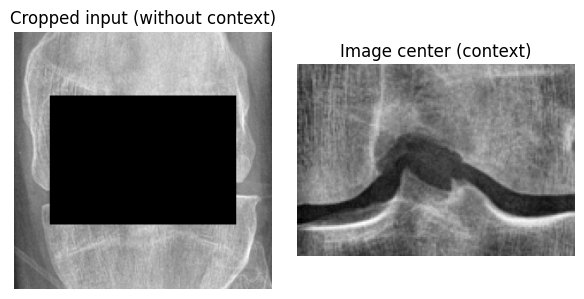

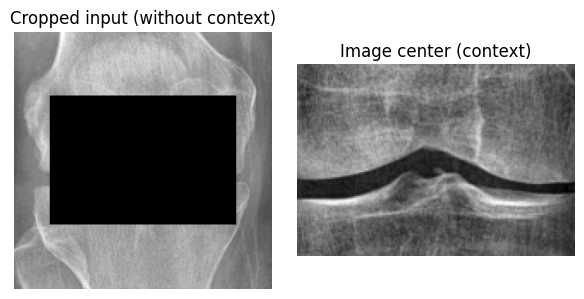

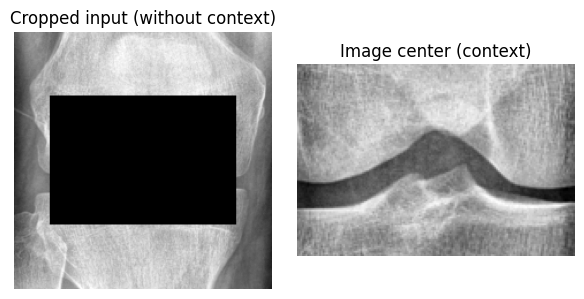

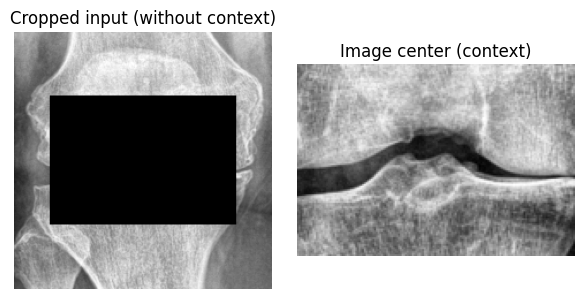

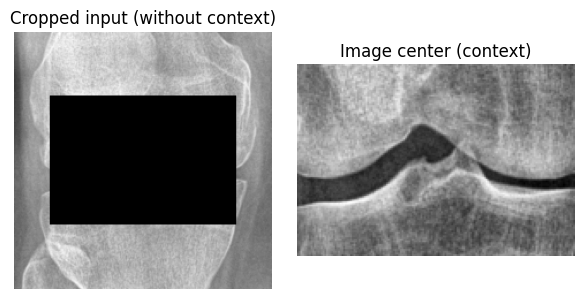

In [ ]:
path = '/content/Data/Unlabeled'
filenames = [name for name in os.listdir(path)]
filenames = random.sample(filenames,5)

df = pd.DataFrame(columns=['file_location', 'file'])
for i, n in enumerate(filenames):
    new = []
    current_path = f"{path}/{n}"
    files = sorted(
        glob.glob(current_path),
        key=lambda var: [int(x) if x.isdigit() else x for x in re.findall(r"[a-zA-Z0-9]+", var)],
    )
    for count, file in enumerate(files):
        file = file.replace('\\', '/')
        new_row = {'file_location': file, 'file': n}
        df = df.append(new_row, ignore_index=True)

clear_output()

# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    # Extract the file path from the 'path' column
    path = row['file_location']
    image = Image.open(path)
    # Calculate the coordinates for the middle region
    start_x = image.size[0] // 4
    start_y = image.size[1] // 4
    end_x = start_x + image.size[0] // 2
    end_y = start_y + image.size[1] // 2
    # Increase the length of the square to capture the entire knee joint region
    length_increase = 25
    start_x -= length_increase
    end_x += length_increase
    # Crop the image to the desired region
    cropped_image = image.crop((start_x, start_y, end_x, end_y))

    # Get the pixels within the coordinates
    pixels = []
    for x in range(cropped_image.size[0]):
        for y in range(cropped_image.size[1]):
            pixel = cropped_image.getpixel((x, y))
            pixels.append(pixel)
    # Create original image without center
    image_without_center = image.copy()
    for i in range(start_x, end_x):
        for j in range(start_y, end_y):
            image_without_center.putpixel((i, j), 0)
    # Convert the list of pixels to a numpy array to create the real center image
    img_array = np.array(pixels, dtype=np.uint8)
    # Reshape the pixels array based on the size of the cropped region
    image_shape = (end_x - start_x, end_y - start_y)
    img_array = img_array.reshape(image_shape).T
    center = Image.fromarray(img_array, mode="L")
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    axs[0].imshow(image_without_center, cmap='gray')
    axs[0].set_title("Cropped input (without context)")
    axs[0].axis('off')

    axs[1].imshow(center, cmap='gray')
    axs[1].set_title("Image center (context)")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

The cropped input image is fed into the generator to create fake centers. These cropped input images are considered as images without context and the task of the generator is to create center images (context). Here context refers to the knee joint region and the images without context referes to the original image without the knee joint region.

These fake centers are discriminated against the real centers by the discriminator which encourages the generator to create realistic center images.


###Build the model
The Generator part of our model consists of an encoder-decoder architecture with convolutional layers and a bottle neck layer that separates the encoder and decoder parts. This part of the model takes in the cropped input image (without context) and generates the context based on the surrounding.

The discriminator part of our model has convolutional layers with a sigmoid activation function that gives the output as real/fake, thus encouraging the generator model to improve quality of generated fakes.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.t1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(1, 1), stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.t2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4, 4), stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.t3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4, 4), stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.t4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(4, 4), stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.t5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(4, 4), stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.t6 = nn.Sequential(
            nn.Conv2d(512, 4000, kernel_size=(4, 4)),  # Bottleneck
            nn.BatchNorm2d(4000),
            nn.ReLU()
        )

        self.t7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=4000, out_channels=512, kernel_size=(4, 4), stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.t8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(4, 4), stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.t9 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(4, 4), stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.t10 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=(4, 4), stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.t1(x)
        x = self.t2(x)
        x = self.t3(x)
        x = self.t4(x)
        x = self.t5(x)
        x = self.t6(x)
        x = self.t7(x)
        x = self.t8(x)
        x = self.t9(x)
        x = self.t10(x)

        # Resize the output to the desired size (112, 162)
        x = nn.functional.interpolate(x, size=(112, 162), mode='bilinear', align_corners=False)

        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.t1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.t2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4, 4), stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.t3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(4, 4), stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.t4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(4, 4), stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.t5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=(1, 1), stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.t1(x)
        x = self.t2(x)
        x = self.t3(x)
        x = self.t4(x)
        x = self.t5(x)
        return x


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.t1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=64, kernel_size=(1, 1), stride=2, padding=1
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.t2 = nn.Sequential(
            nn.Conv2d(
                in_channels=64, out_channels=64, kernel_size=(4, 4), stride=2, padding=1
            ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.t3 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.t4 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.t5 = nn.Sequential(
            nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.t6 = nn.Sequential(
            nn.Conv2d(512, 4000, kernel_size=(4, 4)),  # Bottleneck
            nn.BatchNorm2d(4000),
            nn.ReLU(),
        )

        self.t7 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=4000,
                out_channels=512,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        self.t8 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512,
                out_channels=256,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.t9 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256,
                out_channels=128,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.t10 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=1, kernel_size=(4, 4), stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.t1(x)
        x = self.t2(x)
        x = self.t3(x)
        x = self.t4(x)
        x = self.t5(x)
        x = self.t6(x)
        x = self.t7(x)
        x = self.t8(x)
        x = self.t9(x)
        x = self.t10(x)

        # Resize the output to the desired size (112, 162)
        x = nn.functional.interpolate(
            x, size=(112, 162), mode="bilinear", align_corners=False
        )

        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.t1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=64, kernel_size=(3, 3), stride=2, padding=1
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.t2 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.t3 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.t4 = nn.Sequential(
            nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.t5 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1, kernel_size=(1, 1), stride=1, padding=0
            ),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.t1(x)
        x = self.t2(x)
        x = self.t3(x)
        x = self.t4(x)
        x = self.t5(x)
        return x


### Specify Learning rate and other hyperparameters

In [ ]:
# Specify learning rate and momentum to be used in model training
LEARNING_RATE =0.0002 #@param {type:"number"}
beta1=0.5

In [ ]:
def train_context_encoder(
    dataloader,
    epochs,
    verbose=False,
    retrain=False,
    gen=None,
    disc=None,
    Batch_size=None,
    resume_epoch=0,
):
    wtl2 = 0.999

    # Initialize weights differently for batch normalization layers to further normalize the input activations.
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find("Conv") != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find("BatchNorm") != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

    if retrain == False:

        netG = Generator()
        netG.apply(weights_init)

        netD = Discriminator()
        netD.apply(weights_init)
    else:
        netG = gen

        netD = Discriminator()
        netD.apply(weights_init)
    criterion = nn.BCELoss()
    criterionMSE = nn.MSELoss()

    real_label = 1
    fake_label = 0

    scores = []
    d_loss = []
    g_loss = []
    l2_loss = []
    adv_loss = []

    label = torch.FloatTensor(Batch_size)
    # Initialize the InceptionV3 model
    inception_model = models.inception_v3(pretrained=True)
    inception_model.eval()

    optimizerD = optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(beta1, 0.999))

    for epoch in range(resume_epoch, epochs):
        for i, data in enumerate(dataloader, 1):

            real_cpu, real_center = data

            batch_size = real_cpu.size(0)
            with torch.no_grad():
                input_cropped = real_cpu

            # start the discriminator by training with real data---
            netD.zero_grad()
            with torch.no_grad():
                label = torch.full(
                    (batch_size,), real_label, dtype=label.dtype, device=label.device
                )

            output = netD(real_center)  # 1

            label_save = label

            label = label.view(-1, 1, 1, 1).expand_as(output)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.data.mean()

            # train the discriminator with fake data---
            fake = netG(input_cropped)  # 2
            label = label_save
            label.data.fill_(fake_label)


            # fake being fed in
            output = netD(fake.detach())  # 3
            label = label.view(-1, 1, 1, 1).expand_as(output)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.data.mean()
            errD = errD_real + errD_fake
            optimizerD.step()

            # Training the generator
            netG.zero_grad()
            label.data.fill_(real_label)  # fake labels are real for generator cost
            output = netD(fake)  # 4
            errG_D = criterion(output, label)

            wtl2Matrix = real_center.clone()
            wtl2Matrix.data.fill_(wtl2 * 10)
            wtl2Matrix.data[
                :,
                int((128 - 162) / 2) : int((128 + 162) / 2),
                int((128 - 112) / 2) : int((128 + 112) / 2),
            ] = wtl2

            errG_l2 = (fake - real_center).pow(2)
            errG_l2 = errG_l2 * wtl2Matrix
            errG_l2 = errG_l2.mean()

            errG = (
                1 - wtl2
            ) * errG_D + wtl2 * errG_l2  # l2 loss added with discriminator gives us adverserial loss

            errG.backward()

            D_G_z2 = output.data.mean()
            optimizerG.step()

            if i % 100 == 0:
                try:
                    if verbose:
                        print(
                            "[%d / %d] Loss_D: %.4f Loss_G: %.4f / %.4f l_D(x): %.4f l_D(G(z)): %.4f"
                            % (
                                epoch,
                                epochs,
                                errD.data,
                                errG_D.data,
                                errG_l2.data,
                                D_x,
                                D_G_z1,
                            )
                        )
                    torch.save(
                        netG.state_dict(),
                        "/content/weights/encoder_weights_epoch_%03d.pth" % (epoch),
                    )
                    vutils.save_image(
                        input_cropped.data,
                        "result/train/cropped/cropped_samples_epoch_%03d.png" % (epoch),
                    )
                    recon_image = input_cropped.clone()
                    recon_image.data = fake.data
                    vutils.save_image(
                        fake,
                        "result/train/recon/recon_center_samples_epoch_%03d.png"
                        % (epoch),
                    )
                    vutils.save_image(
                        real_center,
                        "result/train/real_center/real_center_samples_epoch_%03d.png"
                        % (epoch),
                    )
                    d_loss.append(errG_D.data)
                    g_loss.append(errG_l2.data)
                    l2_loss.append(errG_l2.data)
                    adv_loss.append(errG.data)
                    fid_avg = get_batch_fid(fake, real_center, inception_model)
                    scores.append(fid_avg)
                    try:
                        save_files(epoch)
                    except:
                        print("weights unsaved!")
                        pass

                except:

                    d_loss.append(errG_D.data)
                    g_loss.append(errG_l2.data)
                    l2_loss.append(errG_l2.data)
                    adv_loss.append(errG.data)
                    fid_avg = get_batch_fid(fake, real_center, inception_model)
                    scores.append(fid_avg)
                    cropped_samples_dir = "result/train/cropped"
                    recon_samples_dir = "result/train/recon"
                    real_center_samples_dir = "result/train/real_center"
                    weights_dir = "weights/"
                    os.makedirs(cropped_samples_dir, exist_ok=True)
                    os.makedirs(recon_samples_dir, exist_ok=True)
                    os.makedirs(real_center_samples_dir, exist_ok=True)
                    os.makedirs(weights_dir, exist_ok=True)

                    torch.save(
                        netG.state_dict(),
                        "/content/weights/encoder_weights_epoch_%03d.pth" % (epoch),
                    )
                    vutils.save_image(
                        input_cropped.data,
                        "result/train/cropped/cropped_samples_epoch_%03d.png" % (epoch),
                    )
                    recon_image = input_cropped.clone()
                    recon_image.data = fake.data
                    vutils.save_image(
                        real_center.data.detach(),
                        "result/train/real_center/real_center_samples_epoch_%03d.png"
                        % (epoch),
                    )
                    vutils.save_image(
                        recon_image.data.detach(),
                        "result/train/recon/recon_center_samples_epoch_%03d.png"
                        % (epoch),
                    )

    return netG, scores, d_loss, g_loss, l2_loss, adv_loss


### Train Model
Train the model using unlabeled training set. We monitor metrics that are produced during GAN training, such as discriminator loss and generator loss. The former signals how well the discriminator is able to discriminate between fake and real images, while the later helps the generator update its weight according to the discriminator performance.We calcualte Frechet Inception Distance (FID) which is considered a standard for measuring quality of the generated fake images.

In [ ]:
def Average(lst):
    """Return Average of a list"""
    return sum(lst) / len(lst)


def calculate_fid(model, fake_images, real_images):
    """Calculate FID scores for a batch of real and fake images"""
    # Resize images to InceptionV3 input size
    transform = transforms.Compose(
        [
            transforms.Resize(
                (299, 299), antialias=True
            ),
        ]
    )
    # Convert fake and real images to 3 channels suitable for passing into Inception model
    fake_images = convert_to_3_channel(fake_images)
    real_images = convert_to_3_channel(real_images)

    fake_images = transform(
        fake_images
    )
    real_images = transform(real_images)
    # Pass real and fake images through the InceptionV3 model
    fake_activations = (
        model(fake_images).detach().numpy()
    )
    real_activations = (
        model(real_images).detach().numpy()
    )
    # Calculate mean and covariance statistics for fake and real images
    mu1, sigma1 = np.mean(fake_activations, axis=0), np.cov(
        fake_activations, rowvar=False
    )
    mu2, sigma2 = np.mean(real_activations, axis=0), np.cov(
        real_activations, rowvar=False
    )
    # Calculate FID from the mean and covariance of real and fake images
    sigma1 = np.matrix(sigma1)
    sigma2 = np.matrix(sigma2)
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1.dot(sigma2)).real
    if np.iscomplexobj(covmean):  # Check and correct imaginary numbers from sqrt
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)  # Calculate FID score
    return fid

def zip_and_upload_directory(directory_path, zip_file_name):
    '''Create a unique temporary directory for the files to be zipped and uploaded '''
    temp_directory = f'/content/{zip_file_name}'
    shutil.copytree(directory_path, temp_directory)
    zip_file_path = shutil.make_archive(zip_file_name, 'zip', temp_directory)
    file_path = f'/content/{zip_file_name}.zip'
    destination_folder = '/content/drive/MyDrive/Saved_files/'
    shutil.copy(file_path, destination_folder)

def save_files(epoch_num):
    '''save files present in directories '''
    weights_directory = '/content/weights/'
    result_directory = '/content/result/'
    zip_and_upload_directory(weights_directory, "weights_{}".format(int(epoch_num)))
    zip_and_upload_directory(result_directory, "results_{}".format(int(epoch_num)))
    print("Weights saved!")
    return

def get_batch_fid(fake_batch, real_batch, inception_model):
    """Takes in batches and inception model for calculating FID scores"""
    fid = calculate_fid(inception_model, fake_batch, real_batch)
    print("FID (different):", fid)
    return fid


def convert_to_3_channel(images):
    """Takes input image and stack the same image on top of each other to create 3 channels"""
    images = images.repeat(1, 3, 1, 1)

    return images


In [ ]:
%%time
EPOCHS = 50 #@param {type:"integer"}
netG,scores,d_loss,g_loss,l2_loss,adv_loss  = train_context_encoder(dataloader,EPOCHS,verbose=True,gen=reloaded)

[0 / 50] Loss_D: 1.4139 Loss_G: 0.7013 / 1.2174 l_D(x): 0.5281 l_D(G(z)): 0.5306
FID (different): 1301.6187948802583
FID (different): 1301.6187948802583
[0 / 50] Loss_D: 0.9960 Loss_G: 1.1002 / 0.0275 l_D(x): 0.6587 l_D(G(z)): 0.4202
FID (different): 1565.5216420645077
FID (different): 1565.5216420645077
[0 / 50] Loss_D: 0.4370 Loss_G: 1.7507 / 0.0222 l_D(x): 0.8089 l_D(G(z)): 0.1965
FID (different): 1340.2171352999376
FID (different): 1340.2171352999376
[1 / 50] Loss_D: 0.4601 Loss_G: 1.6894 / 0.0195 l_D(x): 0.7826 l_D(G(z)): 0.1887
FID (different): 1247.9761972354208
FID (different): 1247.9761972354208
[1 / 50] Loss_D: 0.6235 Loss_G: 1.0494 / 0.0183 l_D(x): 0.6690 l_D(G(z)): 0.1831
FID (different): 1074.4539835589937
FID (different): 1074.4539835589937
[1 / 50] Loss_D: 0.4925 Loss_G: 2.0966 / 0.0180 l_D(x): 0.8532 l_D(G(z)): 0.2776
FID (different): 1152.5735186906604
FID (different): 1152.5735186906604
[2 / 50] Loss_D: 0.5225 Loss_G: 1.9894 / 0.0153 l_D(x): 0.8502 l_D(G(z)): 0.2901
F

In [ ]:
# Resume training from epoch 5
netG = Generator()
zip_file_path = "/content/drive/MyDrive/Saved_files/weights_5.zip"
unzip_directory = "/content/"
# Now confirm that we can reload it, and it still gives the same results
reloaded = netG.load_state_dict(torch.load('/content/encoder_weights_epoch_005.pth'))

In [ ]:
%%time
netG,scores,d_loss,g_loss,l2_loss,adv_loss  = train_context_encoder(dataloader,EPOCHS,verbose=True,Batch_size=default_batch_size,gen=reloaded,resume_epoch=5)

[5 / 50] Loss_D: 1.4103 Loss_G: 0.7598 / 1.2111 l_D(x): 0.5066 l_D(G(z)): 0.5058
FID (different): 1716.3741236428434
[5 / 50] Loss_D: 1.0390 Loss_G: 0.9791 / 0.0236 l_D(x): 0.5865 l_D(G(z)): 0.3883
FID (different): 1583.4767308587946
Weights saved!
[5 / 50] Loss_D: 0.5099 Loss_G: 1.6446 / 0.0218 l_D(x): 0.7679 l_D(G(z)): 0.2127
FID (different): 1353.7226700963963
FID (different): 1353.7226700963963
[6 / 50] Loss_D: 0.5773 Loss_G: 1.6828 / 0.0209 l_D(x): 0.7637 l_D(G(z)): 0.2571
FID (different): 1294.2130841442133
Weights saved!
[6 / 50] Loss_D: 0.6709 Loss_G: 1.2096 / 0.0171 l_D(x): 0.7455 l_D(G(z)): 0.2897
FID (different): 1063.6835960660487
FID (different): 1063.6835960660487
[6 / 50] Loss_D: 1.1203 Loss_G: 1.1013 / 0.0137 l_D(x): 0.5011 l_D(G(z)): 0.2588
FID (different): 1065.7367603112898
FID (different): 1065.7367603112898
[7 / 50] Loss_D: 0.4908 Loss_G: 1.5732 / 0.0152 l_D(x): 0.7723 l_D(G(z)): 0.1875
FID (different): 1069.2586183466506
Weights saved!
[7 / 50] Loss_D: 0.2913 Loss

In [ ]:
%%time
netG,scores,d_loss,g_loss,l2_loss,adv_loss  = train_context_encoder(dataloader,EPOCHS,verbose=True,retrain=True,Batch_size=default_batch_size,gen=netG,resume_epoch=12)

[12 / 50] Loss_D: 1.4095 Loss_G: 0.8852 / 0.0195 l_D(x): 0.4584 l_D(G(z)): 0.4583
FID (different): 1101.3242317197046
FID (different): 1101.3242317197046
[12 / 50] Loss_D: 1.0437 Loss_G: 0.9624 / 0.0126 l_D(x): 0.5944 l_D(G(z)): 0.4015
FID (different): 1142.8719669448071
FID (different): 1142.8719669448071
[13 / 50] Loss_D: 1.0173 Loss_G: 0.9247 / 0.0247 l_D(x): 0.6254 l_D(G(z)): 0.4117
FID (different): 1047.4565631263515
FID (different): 1047.4565631263515


In [ ]:
# Resume training from epoch 12
netG = Generator()
zip_file_path = "/content/drive/MyDrive/Saved_files/weights_13.zip"
unzip_directory = "/content/"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_directory)

# Now confirm that we can reload it, and it still gives the same results
netG.load_state_dict(torch.load('/content/encoder_weights_epoch_013.pth'))

<All keys matched successfully>

We notice that the Frechet Inception Distance score does not decrease as training progresses and so, we switch on focus thresholding which removes blurry images from the training set.

In [ ]:
# Let's reject unfocused images using focus thresholding
Focus_thresholding = True #@param {type:"boolean"}
default_batch_size = 32
dataset = SingleClassDataset(root, crop_length=25,make_corrections=correct_negatives_images,Focus_thresholding = Focus_thresholding,  transform=transform)
dataloader = DataLoader(dataset, batch_size=default_batch_size, shuffle=True,drop_last=False)

In [ ]:
%%time
RESUME_EPOCH = 13 #@param {type:"integer"}
netG,scores,d_loss,g_loss,l2_loss,adv_loss  = train_context_encoder(dataloader,EPOCHS,verbose=True,retrain=True,Batch_size=default_batch_size,gen=netG,resume_epoch=RESUME_EPOCH)

[13 / 50] Loss_D: 1.4116 Loss_G: 0.8209 / 0.0141 l_D(x): 0.5187 l_D(G(z)): 0.5183
FID (different): 1099.2007624668843
FID (different): 1099.2007624668843
[13 / 50] Loss_D: 1.0780 Loss_G: 0.9349 / 0.0100 l_D(x): 0.6058 l_D(G(z)): 0.4236
FID (different): 1088.7572728240846
FID (different): 1088.7572728240846
[14 / 50] Loss_D: 1.0449 Loss_G: 0.9923 / 0.0163 l_D(x): 0.6348 l_D(G(z)): 0.4407
FID (different): 1306.1999376275305
Weights saved!
[14 / 50] Loss_D: 0.7147 Loss_G: 1.2655 / 0.0086 l_D(x): 0.7089 l_D(G(z)): 0.2994
FID (different): 1042.9759468240084
FID (different): 1042.9759468240084
[15 / 50] Loss_D: 0.8183 Loss_G: 1.1806 / 0.0197 l_D(x): 0.6604 l_D(G(z)): 0.3094
FID (different): 1306.9278925389456
Weights saved!
[15 / 50] Loss_D: 0.3570 Loss_G: 1.8578 / 0.0075 l_D(x): 0.8311 l_D(G(z)): 0.1541
FID (different): 1083.5464449459369
FID (different): 1083.5464449459369
[16 / 50] Loss_D: 0.4191 Loss_G: 1.7923 / 0.0166 l_D(x): 0.8256 l_D(G(z)): 0.1910
FID (different): 1352.0198271832314


In [ ]:
# Resume training from epoch 17
netG = Generator()
zip_file_path = "/content/drive/MyDrive/Saved_files/weights_17.zip"
unzip_directory = "/content/"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_directory)
netG.load_state_dict(torch.load('/content/encoder_weights_epoch_017.pth'))

<All keys matched successfully>

In [ ]:
%%time
netG,scores,d_loss,g_loss,l2_loss,adv_loss  = train_context_encoder(dataloader,EPOCHS,verbose=True,retrain=True,Batch_size=default_batch_size,gen=netG,resume_epoch=18)

[18 / 50] Loss_D: 1.4211 Loss_G: 0.9292 / 0.0163 l_D(x): 0.4544 l_D(G(z)): 0.4540
FID (different): 1428.9770419111107
Weights saved!
[18 / 50] Loss_D: 1.0120 Loss_G: 0.9486 / 0.0083 l_D(x): 0.6112 l_D(G(z)): 0.3992
FID (different): 1037.799036409635
FID (different): 1037.799036409635
[19 / 50] Loss_D: 1.0104 Loss_G: 0.8766 / 0.0229 l_D(x): 0.6008 l_D(G(z)): 0.3866
FID (different): 1227.720782795407
Weights saved!
[19 / 50] Loss_D: 0.4494 Loss_G: 1.6188 / 0.0063 l_D(x): 0.7918 l_D(G(z)): 0.1910
FID (different): 1059.4563021633849
FID (different): 1059.4563021633849
[20 / 50] Loss_D: 0.4312 Loss_G: 1.6700 / 0.0090 l_D(x): 0.8222 l_D(G(z)): 0.2043
FID (different): 1147.1755036742113
Weights saved!
[20 / 50] Loss_D: 0.1932 Loss_G: 2.4540 / 0.0058 l_D(x): 0.9082 l_D(G(z)): 0.0909
FID (different): 1018.8092675517873
FID (different): 1018.8092675517873
[21 / 50] Loss_D: 0.1998 Loss_G: 2.4397 / 0.0189 l_D(x): 0.9046 l_D(G(z)): 0.0887
FID (different): 1435.4022982157787
Weights saved!
[21 / 50]

In [ ]:
# Resume training from epoch 22
netG = Generator()
zip_file_path = "/content/drive/MyDrive/Saved_files/weights_22.zip"
unzip_directory = "/content/"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_directory)
netG.load_state_dict(torch.load('/content/encoder_weights_epoch_022.pth'))

<All keys matched successfully>

In [ ]:
%%time
netG,scores,d_loss,g_loss,l2_loss,adv_loss  = train_context_encoder(dataloader,EPOCHS,verbose=True,retrain=True,Batch_size=default_batch_size,gen=netG,resume_epoch=23)

[23 / 50] Loss_D: 1.4226 Loss_G: 0.8665 / 0.0104 l_D(x): 0.4592 l_D(G(z)): 0.4599
FID (different): 1409.9665577830074
Weights saved!
[23 / 50] Loss_D: 1.0662 Loss_G: 0.8935 / 0.0075 l_D(x): 0.6010 l_D(G(z)): 0.4242
FID (different): 1035.3948432918962
FID (different): 1035.3948432918962
[23 / 50] Loss_D: 0.5650 Loss_G: 1.4697 / 0.0071 l_D(x): 0.7459 l_D(G(z)): 0.2297
FID (different): 992.5442609763504
FID (different): 992.5442609763504
[24 / 50] Loss_D: 0.4044 Loss_G: 1.7304 / 0.0078 l_D(x): 0.8118 l_D(G(z)): 0.1752
FID (different): 951.4360621099902
Weights saved!
[24 / 50] Loss_D: 0.1957 Loss_G: 2.4143 / 0.0060 l_D(x): 0.9066 l_D(G(z)): 0.0922
FID (different): 1081.3129176691098
FID (different): 1081.3129176691098
[24 / 50] Loss_D: 0.0963 Loss_G: 3.0780 / 0.0064 l_D(x): 0.9543 l_D(G(z)): 0.0481
FID (different): 996.0705035812058
FID (different): 996.0705035812058
[25 / 50] Loss_D: 0.0838 Loss_G: 3.2279 / 0.0054 l_D(x): 0.9617 l_D(G(z)): 0.0434
FID (different): 1049.0002933672279
Weigh

In [ ]:
%%time
netG,scores,d_loss,g_loss,l2_loss,adv_loss  = train_context_encoder(dataloader,EPOCHS,verbose=True,retrain=True,Batch_size=default_batch_size,gen=netG,resume_epoch=27)

[27 / 50] Loss_D: 1.4233 Loss_G: 0.8211 / 0.0045 l_D(x): 0.4934 l_D(G(z)): 0.4932
FID (different): 877.9382925678555
Weights saved!
[27 / 50] Loss_D: 1.0614 Loss_G: 0.8846 / 0.0051 l_D(x): 0.5998 l_D(G(z)): 0.4181
FID (different): 918.3413573153767
FID (different): 918.3413573153767
[28 / 50] Loss_D: 1.1781 Loss_G: 0.8424 / 0.0097 l_D(x): 0.6118 l_D(G(z)): 0.4919
FID (different): 1154.37138216853
Weights saved!
[28 / 50] Loss_D: 0.5509 Loss_G: 1.5096 / 0.0044 l_D(x): 0.7529 l_D(G(z)): 0.2263
FID (different): 812.7599551339998
FID (different): 812.7599551339998
[29 / 50] Loss_D: 0.5619 Loss_G: 1.5211 / 0.0079 l_D(x): 0.7675 l_D(G(z)): 0.2426
FID (different): 1081.0718473775219
Weights saved!
[29 / 50] Loss_D: 0.2244 Loss_G: 2.3784 / 0.0043 l_D(x): 0.8874 l_D(G(z)): 0.0939
FID (different): 796.2360491202921
FID (different): 796.2360491202921
[30 / 50] Loss_D: 0.4781 Loss_G: 1.8332 / 0.0174 l_D(x): 0.8609 l_D(G(z)): 0.2390
FID (different): 1255.4858007246066
Weights saved!
[30 / 50] Loss_

In [ ]:
# Resume training from epoch 31
netG = Generator()
zip_file_path = "/content/weights_32.zip"
unzip_directory = "/content/"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_directory)
netG.load_state_dict(torch.load('/content/encoder_weights_epoch_032.pth'))

<All keys matched successfully>

In [ ]:
%%time
try:
  netG,scores,d_loss,g_loss,l2_loss,adv_loss  = train_context_encoder(dataloader,EPOCHS,verbose=True,retrain=True,Batch_size=default_batch_size,gen=netG,resume_epoch=33)
except KeyboardInterrupt:
    # Code to execute on keyboard interrupt
    print("Session interrupt detected. Shutting down gracefully.")


[33 / 50] Loss_D: 1.1188 Loss_G: 0.8120 / 0.0048 l_D(x): 0.5656 l_D(G(z)): 0.4170
FID (different): 869.6763986160959
weights unsaved!
[33 / 50] Loss_D: 0.5780 Loss_G: 1.4557 / 0.0045 l_D(x): 0.7580 l_D(G(z)): 0.2523
FID (different): 807.6568630494867
weights unsaved!
[34 / 50] Loss_D: 0.2013 Loss_G: 2.4444 / 0.0041 l_D(x): 0.8980 l_D(G(z)): 0.0876
FID (different): 821.131717640033
Weights saved!


In [ ]:
# Resume training from epoch 34
netG = Generator()
zip_file_path = "/content/drive/MyDrive/Saved_files/weights_34.zip"
unzip_directory = "/content/"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_directory)
# Now confirm that we can reload it, and it still gives the same results
reloaded = netG.load_state_dict(torch.load('/content/encoder_weights_epoch_034.pth'))

In [ ]:
%%time
try:
  netG,scores,d_loss,g_loss,l2_loss,adv_loss  = train_context_encoder(dataloader,EPOCHS,verbose=True,retrain=True,Batch_size=default_batch_size,gen=netG,resume_epoch=34)
except KeyboardInterrupt:
    # Code to execute on keyboard interrupt
    print("Session interrupt detected. Shutting down gracefully.")


[34 / 50] Loss_D: 1.0970 Loss_G: 0.9255 / 0.0045 l_D(x): 0.5920 l_D(G(z)): 0.4150
FID (different): 866.9744995324016
[34 / 50] Loss_D: 0.5267 Loss_G: 1.5588 / 0.0046 l_D(x): 0.7777 l_D(G(z)): 0.2361
FID (different): 787.2675250316036
Weights saved!
[35 / 50] Loss_D: 0.2900 Loss_G: 2.2439 / 0.0044 l_D(x): 0.8443 l_D(G(z)): 0.1096
FID (different): 791.3599582706125
Weights saved!
[35 / 50] Loss_D: 0.1123 Loss_G: 2.9105 / 0.0043 l_D(x): 0.9478 l_D(G(z)): 0.0566
FID (different): 843.8156598794366
weights unsaved!
[36 / 50] Loss_D: 0.0613 Loss_G: 3.5202 / 0.0043 l_D(x): 0.9726 l_D(G(z)): 0.0329
FID (different): 803.498713238149
Weights saved!
[36 / 50] Loss_D: 0.0711 Loss_G: 3.5097 / 0.0047 l_D(x): 0.9617 l_D(G(z)): 0.0313
FID (different): 837.8471246375128
weights unsaved!
[37 / 50] Loss_D: 0.0370 Loss_G: 4.0128 / 0.0040 l_D(x): 0.9829 l_D(G(z)): 0.0195
FID (different): 820.9631801126785
Weights saved!
[37 / 50] Loss_D: 0.0276 Loss_G: 4.3602 / 0.0041 l_D(x): 0.9863 l_D(G(z)): 0.0136
FID (d

In [ ]:
#Ressume training from epoch 11
netG = Generator()
zip_file_path = "/content/drive/MyDrive/Saved_files/weights_38.zip"
unzip_directory = "/content/"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_directory)
# Now confirm that we can reload it, and it still gives the same results
reloaded = netG.load_state_dict(torch.load('/content/encoder_weights_epoch_038.pth'))

In [ ]:
%%time
try:
  netG,scores,d_loss,g_loss,l2_loss,adv_loss  = train_context_encoder(dataloader,EPOCHS,verbose=True,retrain=True,Batch_size=default_batch_size,gen=netG,resume_epoch=39)
except KeyboardInterrupt:
    # Code to execute on keyboard interrupt
    print("Session interrupt detected. Shutting down gracefully.")


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 212MB/s]


[39 / 50] Loss_D: 1.2131 Loss_G: 0.8296 / 0.0036 l_D(x): 0.5414 l_D(G(z)): 0.4338
FID (different): 779.2016751534992
[39 / 50] Loss_D: 0.5994 Loss_G: 1.4135 / 0.0038 l_D(x): 0.7415 l_D(G(z)): 0.2497
FID (different): 719.3001382628227
Weights saved!
[40 / 50] Loss_D: 0.2115 Loss_G: 2.3331 / 0.0042 l_D(x): 0.9017 l_D(G(z)): 0.1015
FID (different): 794.5129341650633
Weights saved!
[40 / 50] Loss_D: 0.1200 Loss_G: 2.8802 / 0.0043 l_D(x): 0.9414 l_D(G(z)): 0.0575
FID (different): 741.9387217703285
weights unsaved!
[41 / 50] Loss_D: 0.0830 Loss_G: 3.2295 / 0.0036 l_D(x): 0.9601 l_D(G(z)): 0.0411
FID (different): 738.2074094791147
Weights saved!
[41 / 50] Loss_D: 0.0567 Loss_G: 3.6220 / 0.0042 l_D(x): 0.9720 l_D(G(z)): 0.0278
FID (different): 730.1706184198251
weights unsaved!
[42 / 50] Loss_D: 0.0376 Loss_G: 3.9999 / 0.0047 l_D(x): 0.9818 l_D(G(z)): 0.0191
FID (different): 735.3856582170501
Weights saved!
[42 / 50] Loss_D: 0.0325 Loss_G: 4.1898 / 0.0042 l_D(x): 0.9839 l_D(G(z)): 0.0160
FID (

The time taken displayed by the previous cell shows us that, it took 8 hours to train 12 epochs. The total model training time took 35 hours, and we save the model weights at two points in each epoch, so that we can resume training after loading the saved weights.

With the available resources, we were able to train the model for 50 epochs and we can see that the FID scores decrease after we switched on focus thresholding which led to higher quality fake images generated by our encoder-decoder architecture.

Let's save the metrics from our model to check for model collapse and other visible patterns from the FID scores generated in each epoch.

In [ ]:
get_files(file='saved_weights')

In [ ]:
# save metrics
lists = [d_loss,g_loss,l2_loss,adv_loss]
list_names = ["loss_d", "loss_g", "l_d_x", "l_d_g_z"]

directory = "lists"
os.makedirs(directory, exist_ok=True)

for lst, name in zip(lists, list_names):
    with open(f"{directory}/{name}.txt", "w") as file:
        file.write("\n".join(str(value) for value in lst))

shutil.make_archive("lists", "zip", directory)

###Check Performance
Plot Discriminator, generator loss to check for model collapse.

In [ ]:
# Reload the lists from the text files
loss_d = []
loss_g = []
unzip_directory = "/content/"

list_names = ["loss_d", "loss_g"]
for name in list_names:
    file_path = os.path.join(unzip_directory, f"{name}.txt")
    with open(file_path, "r") as file:
        values = [float(value) for value in file.readlines()]
        if name == "loss_d":
            loss_d = values
        elif name == "loss_g":
            loss_g = values

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss_d,label='Discriminator loss')
plt.plot(loss_g,label='Generator loss')
plt.legend()
plt.plot()

From the above plot we can see that, the generator loss is higher than the discriminator loss with a value above 0.5 which indicates that the generator is continually improving performance as training of the generative model progresses. A model collapse could also be identified by lack of diversity of generated images, lets check the generated images as follows.

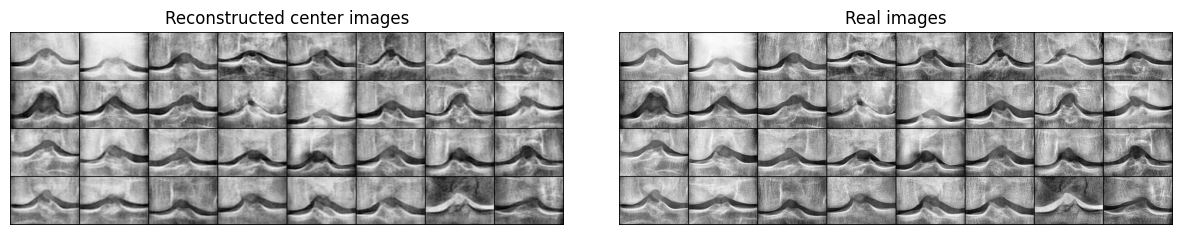

In [ ]:
path_results = "/content/train/recon/recon_center_samples_epoch_045.png"
path_original = "/content/train/real_center/real_center_samples_epoch_045.png"
image1 = Image.open(path_results)
image2 = Image.open(path_original)
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(image1)
ax1.set_title("Reconstructed center images")
ax1.axis("off")
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(image2)
ax2.set_title("Real images")
ax2.axis("off")
plt.subplots_adjust(wspace=0.1)
plt.show()

Here we can see that there is huge diversity between each reconstructed center image. The only method to visually differentiate the generated fake and real images would be the blur in the reconstructed images.

## Export as saved model to be fine-tuned using pool 1 images
Now that we have trained the model, export it as a saved model

In [ ]:
t = time.time()
export_path = "/content/weights/saved_model_{}".format(int(t))
torch.save(netG.state_dict(),export_path)

In [ ]:
get_files(file='saved_weights')
netG = Generator()
# Now confirm that we can reload it, and it still gives the same results
reloaded = netG.load_state_dict(torch.load('/content/encoder_weights_epoch_045.pth'))

## Random test
Random sample images from dataset and create fake centers for maual inspection

F. Prezja et al. [1]  utilized Frechet Inception Distance (FID) for model selection and so following their method we reload the model weights which produced the lowest FID scores and generate a fake center for an image.

Generated fake


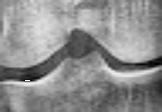

original


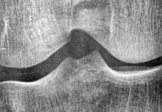

Calculating FID Score by comparing 32 fake and real images
FID: 666.400815


In [ ]:
def predict_reload(reloaded,input_cropped,  real_center, inception_model,separate=True):
    fake = reloaded(input_cropped)

    # Select the specific image from the batch
    example_real_image = real_center[0]
    example_fake_image = fake[0]
    # Convert the tensor to PIL Image
    to_pil = transforms.ToPILImage()
    rl = to_pil(example_real_image)
    fk = to_pil(example_fake_image)
    if separate:
      print("Generated fake")
      display(fk)
      print("original")
      display(rl)
      print("Calculating FID Score by comparing %d fake and real images" % (fake.size(0)))
      fid = calculate_fid(inception_model, fake, real_center)

      return fid
    else:
      input_cropped = (input_cropped.squeeze())
      input_cropped =  to_pil(input_cropped)
      start_x = input_cropped.size[0] // 4
      start_y = input_cropped.size[1] // 4
      end_x = start_x + input_cropped.size[0] // 2
      end_y = start_y + input_cropped.size[1] // 2
      # Increase the length of the square to capture the entire knee joint region
      length_increase = 25
      start_x -= length_increase
      end_x += length_increase
      # Convert 'input_cropped' to a NumPy array
      input_cropped_array = np.array(input_cropped)
      # Convert 'fk' to a NumPy array
      fk_array = np.array(fk)
      # Copy the 'input_cropped_array' to a new array to avoid modifying the original
      result_array = input_cropped_array.copy()
      # Resize 'fk_array' to match the specified region size
      fk_array_resized = cv2.resize(fk_array, (end_x - start_x, end_y - start_y))
      # Replace the values in the specified coordinates with 'fk_array' values
      result_array[start_y:end_y, start_x:end_x] = fk_array_resized
      og_result_array = result_array
      rl_array = np.array(rl)
      # Copy the 'input_cropped_array' to a new array to avoid modifying the original
      result_array = input_cropped_array.copy()
      # Resize 'fk_array' to match the specified region size
      rl_array_resized = cv2.resize(rl_array, (end_x - start_x, end_y - start_y))
      # Replace the values in the specified coordinates with 'fk_array' values
      result_array[start_y:end_y, start_x:end_x] = rl_array_resized
      # Create a subplot with two columns
      fig, ax1 = plt.subplots(1, 2)

      # Display the first image
      ax1[0].imshow(og_result_array, cmap='gray')
      ax1[0].set_title("Inpainted image")

      # Display the second image
      ax1[1].imshow(result_array, cmap='gray')
      ax1[1].set_title("original")
      plt.show()


def ignore_warnings():
  os.environ['PYTHONWARNINGS'] = "ignore"
  with warnings.catch_warnings():
      warnings.simplefilter("ignore")
  warnings.filterwarnings("ignore", category=UserWarning, module="torchvision.models")


ignore_warnings()


# Initialize the InceptionV3 model
inception_model = models.inception_v3(pretrained=True)
inception_model.eval()

for cropped_img, center_img in dataloader:

    # print("SOURCE:  file: %s" % (os.path.split(filename)[0], filename))
    fid = predict_reload(netG,cropped_img, center_img, inception_model)
    print("FID: %f" % fid)
    break

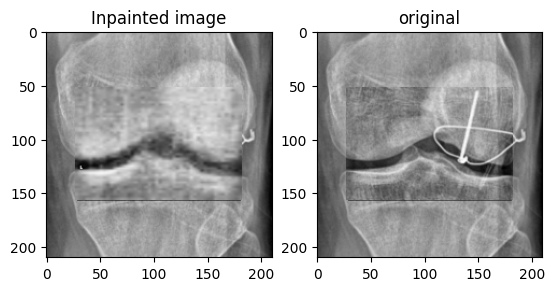

In [ ]:

# Load the "Artifacts" dataset
artifacts_dataset =  SingleClassDataset(
    "Data/Artifacts/", crop_length=25, make_corrections=correct_negatives_images,Focus_thresholding = Focus_thresholding,  transform=transform)

artifacts_dataloader = DataLoader(artifacts_dataset, batch_size=1, shuffle=True,drop_last=True)

for cropped_img, center_img in artifacts_dataloader:
    predict_reload(netG, cropped_img, center_img, inception_model,separate=False)
    break


## Conclusion

The model can be improved if we tune hyperparameters and train it for a higher number of epochs. The generated fakes show that the generator part of our model is able to recreate the joint portion of knee radiographs. Thus we can utilize this encoder model to convert images with surgical artifacts into images without artifacts and re-introduce them into training/testing sets.

# Reference

[1] F. Prezja, J. Paloneva, I. Pölönen, E. Niinimäki and S. Äyrämö, "DeepFake knee osteoarthritis X-rays from generative adversarial neural networks deceive medical experts and offer augmentation potential to automatic classification," in Proceedings of the IEEE International Conference on Artificial Intelligence in Medicine (AI-Med), Year, Pages.
https://www.nature.com/articles/s41598-022-23081-4